# ROXSI 2022 SSA Nortek Signature 1000
Visualize Sig1000 data QC and statistical parameters from ROXSI 2022 Asilomar Small-Scale Array measurements.

In [1]:
# Imports
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
from pyproj import Proj
import cmocean
import ipympl
import matplotlib.pyplot as plt
# Interactive plots
%matplotlib widget 


In [2]:
# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
# Choices: ['103088', '103094', '103110', '103063', '103206']
ser = 103094

# Visualize one date or all dates?
date = '2022-07-01'
# date = 'all'

## Read and plot bathymetry
First plot closeups of SSA bathymetry with Signature moorings marked with triangles.

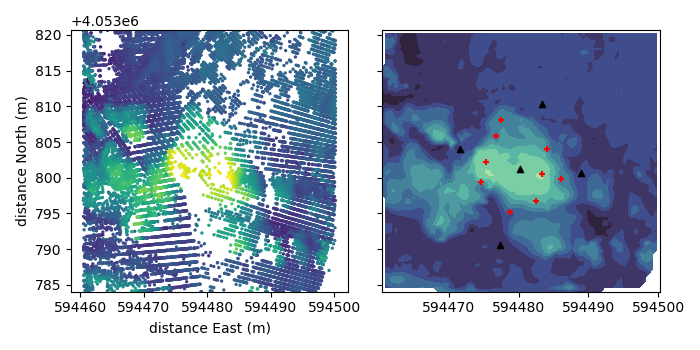

In [6]:
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Initialize figure and plot
plt.close()
fig, axes = plt.subplots(figsize=(7,3.5), ncols=2, constrained_layout=True,
                         sharey=True)
axes[0].scatter(dsb.x_pts, dsb.y_pts, c=dsb.z_pts, s=2)
axes[0].set_xlabel('Eastings (m)')
axes[0].set_ylabel('Northings (m)')
axes[1].contourf(dsb.eastings, dsb.northings, dsb.z_utm, vmin=-8.0, vmax=-3.5,
                 cmap=cmocean.cm.deep_r)
# Mooring locations
s = 20 # markersize
axes[1].scatter(dsb.C1_utm[0].item(), dsb.C1_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.C2_utm[0].item(), dsb.C2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C3_utm[0].item(), dsb.C3_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.C4_utm[0].item(), dsb.C4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C5_utm[0].item(), dsb.C5_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C6_utm[0].item(), dsb.C6_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.L1_utm[0].item(), dsb.L1_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.L2_utm[0].item(), dsb.L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.L4_utm[0].item(), dsb.L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.L5_utm[0].item(), dsb.L5_utm[1].item(), marker='^', color='k', s=s)
axes[1].scatter(dsb.C2L2_utm[0].item(), dsb.C2L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C2L4_utm[0].item(), dsb.C2L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C4L2_utm[0].item(), dsb.C4L2_utm[1].item(), marker='+', color='r', s=s)
axes[1].scatter(dsb.C4L4_utm[0].item(), dsb.C4L4_utm[1].item(), marker='+', color='r', s=s)
axes[1].set_xlabel('Eastings (m)')

plt.tight_layout()
plt.show()


## Read Level2 data
If visualizing all dates, concatenate daily netcdf files into one xr.Dataset.